# Chapter 6: Introduction to Diffusion Models

This chapter covers:

* How the forward diffusion process gradually adds noise to images
* How the reverse diffusion process iteratively removes noise to create a clean image
* Building and training a denoising U-Net model
* Using the trained U-Net to generate clothing item images

Broadly speaking, there are two ways to generate images from text prompts: vision Transformers (ViT) and diffusion models. In the first method, we divide an image into multiple patches and treat each patch as an element in a sequence. As a result, image generation becomes a sequence prediction problem. When generating an image based on a text prompt, we ask the trained ViT to first predict the top left patch. In the next iteration, we feed the first patch, along with the conditioning information based on the text prompt, to the ViT and ask it to predict the second patch. We repeat the process until we have all the needed patches in the image. 

The second way to generate images based on text descriptions is through diffusion models. We start with an image with pure noise. We ask the trained diffusion model to denoise it slightly, conditional on the text prompt. The result is a less noisy image. We repeat the process many times until we obtain a clean image that matches the text prompt. Diffusion models have become the go-to generative model by learning progressively removing noise from noisy images. They form the foundation of the state of the art text to image models, including Imagen, DALL-E 2 (though not DALL-E), and Stable Diffusion. 

This chapter discusses the basic idea behind diffusion models. Understanding the diffusion mechanism is particularly crucial for comprehending text-to-image models, as diffusion models form the foundation of all leading text-to-image models. For this reason, you will start by building and training a diffusion model to generate hand-written digits in this chapter. This will provide you with a deep understanding of the forward diffusion process, where noise is incrementally added to images until they become random noise. Subsequently, you will train a model to reverse the diffusion process by gradually removing noise from images until the model can generate a new, clean image from random noise, resembling those in the training dataset. 

In particular, this chapter focuses on the forward diffusion process: adding noise to images gradually till they become pure noise. You'll also learn different diffusion schedules: linear versus cosine, and how the two schedules differ. 

# 1.    The Forward Diffusion Process
The idea of diffusion-based models is as follows. Imagine you want to train a diffusion model to generate high-resolution images. You first acquire a set of images for training. You'll gradually introduce small amounts of random noise into these images. This process is known as forward diffusion. After many steps of adding noise, the training images become random noise. 

You'll then train the model to reverse this process, a process known as the reverse diffusion process (or the denoising process). Specifically, you'll start with random noise images and progressively reduce the noise until the images are indistinguishable from those in the original training set.
The trained diffusion model can use random noise images as a starting point. It gradually eliminates noise from the image over many iterations until it generates a high-resolution image that resembles those in the training set. This is the underlying principle of diffusion-based models.
 
In this section, you will first explore the theoretical foundations of diffusion-based models. Then, you will explore two different ways of noise scheduling: the linear noising schedule and the cosine noising schedule. You'll compare them side by side to see how noise is added to images until they become random noise images, similar to snowflakes on a TV screen. 

## 1.1 How Diffusion Models Work
The idea behind diffusion models are proposed by several papers with similar underlying mechanisms. The first one is the 2015 paper by Jascha Sohl-Dickstein, Eric A. Weiss, Niru Maheswaranathan, and Surya Ganguli, Deep Unsupervised Learning Using Nonequilibrium Thermodynamics (https://arxiv.org/abs/1503.03585). The second one is Yang Song and Stefano Ermon, 2019, Generative Modeling by Estimating Gradients of the Data Distribution (https://arxiv.org/abs/1907.05600). The third one is by Jonathan Ho, Ajay Jain, and Pieter Abbeel in 2020, Denoising Diffusion Probabilistic Models (https://arxiv.org/abs/2006.11239). 

Let’s use an image of a deer as a concrete example to explain the idea behind denoising diffusion models.
Figure.1 is a diagram of how the forward diffusion process works. 
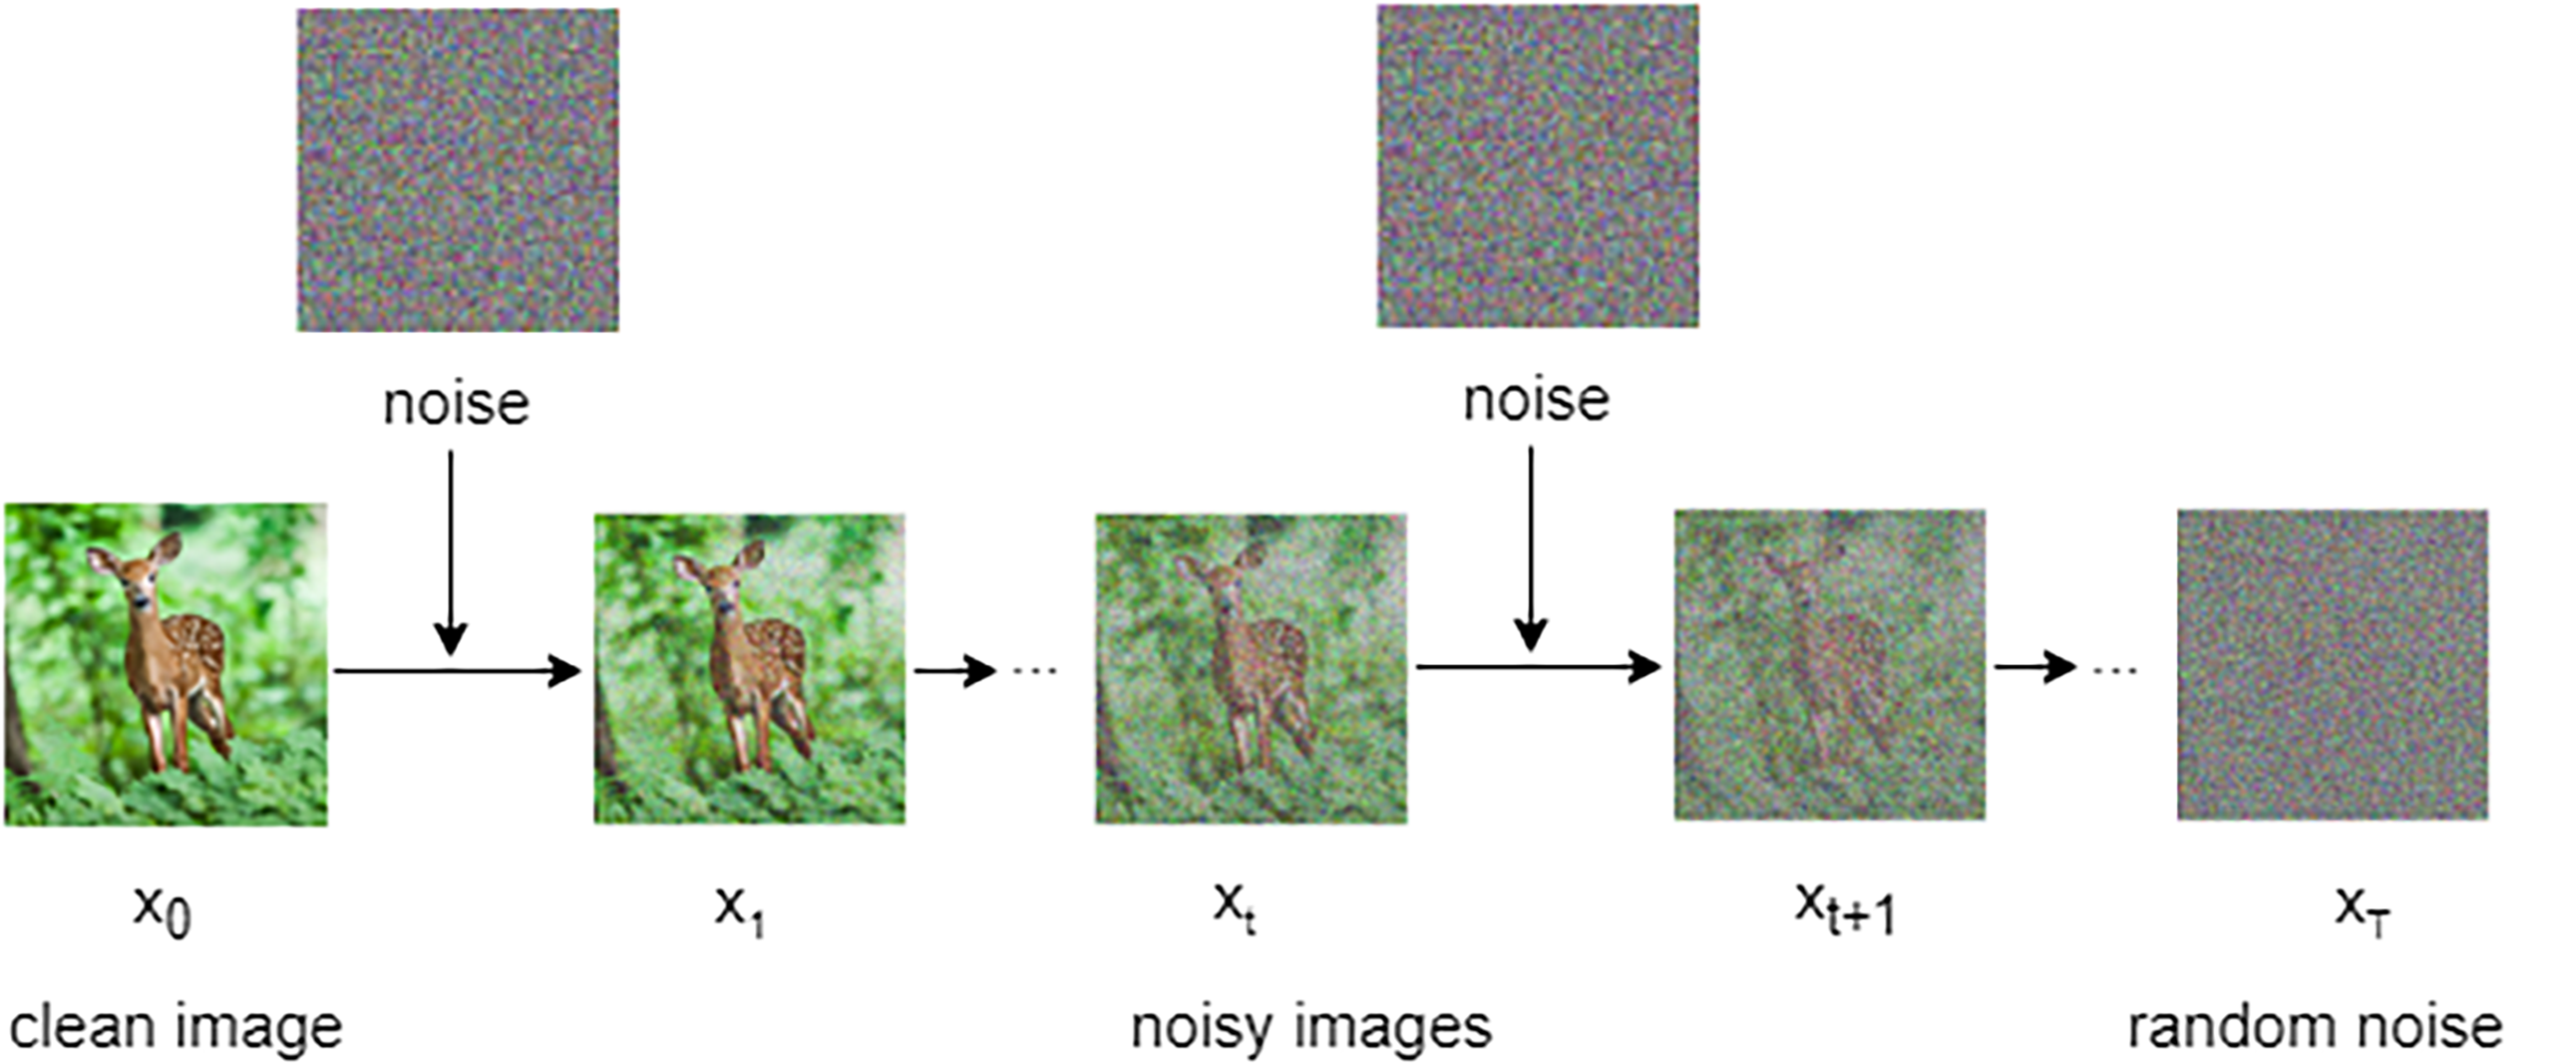

Figure 1: A diagram of the forward diffusion process. We start with a clean image, $x_0$, and add noise to it to form a noisy image $x_1$. We repeat this process for T time steps until the image $x_T$ becomes random noise. 


We start with a clean image, $x_0$, which is illustrated in the left image in figure 1), follow a distribution of q(x). We can normalize the value of x so that it has zero mean and unit standard deviation. In the forward diffusion process, we’ll add small amounts of noise to the images in each of the T steps (for example, T=1000). The noise tensor follows a standard normal distribution and has the same shape as the clean images. Eventually, $x_T$ approximates a standard normal distribution. 

In time step 1, we add noise $ϵ_0$ to the image $x_0$, to obtain a noisy image $x_1$, like this:
$$x_1 = \sqrt{1-\beta_1} x_0 + \sqrt{\beta_1} \epsilon_0 $$

Here, $x_1$ is a weighted sum of $x_0$ and $ϵ_0$, and $β_1$ measures the weight placed on the noise. The value of $β$ changes in different time steps, hence the subscript in $β_1$. If we assume $x_0$ and $ϵ_0$ both have a mean of 0 and a variance of 1, the noisy image $x_1$ will also have zero mean and unit variance. 

We can keep adding noise to the image for the next T-1 time steps so that: $$x_{t+1} = \sqrt{1-\beta_{t+1}} x_t + \sqrt{\beta_{t+1}} \epsilon_t $$

We can use a reparameterization trick and define $α_t=1-β_t$  and $\bar{α}_t=∏_{k=1}^t α_k$  to allow us to sample $x_t$ at any arbitrary time step t, where t can take any value in [1, 2, …, T-1, T]. Then we have 
$$x_{t} = \sqrt{\bar{α}_t} x_0 + \sqrt{1-\bar{α}_t}\  \epsilon $$

We'll then construct a deep neural network as the denoising model to reverse the diffusion process, which is called the denoising process. If we can train a model to reverse the forward diffusion process, we can feed the model with random noise and ask it to produce a noisy image. We can then feed the noisy image to the trained model again and produce a clearer, though still noisy, image. We can iteratively repeat the process for many time steps until we obtain a clean image. This is the idea behind diffusion models. In later sections, we'll discuss in detail the reverse diffusion process and how to train the diffusion model.

## 1.2 Visualize the forward diffusion process
We mentioned above that the value of $β$ changes in different time steps, hence the subscript in $β_t$. In the paper by Jonathan Ho, Ajay Jain, and Pieter Abbeel in 2020, Denoising Diffusion Probabilistic Models, a linear diffusion schedule is chosen. That is, the value of $β_t$ increases linearly with the timestep t, from $β_1=0.0001$ to $β_T=0.02$. Let's code that in Python as follows: 

In [1]:
import torch

# assuming 1000 time steps
T=1000
# relative timesteps [0/1000, 1/1000,...,1000/1000]
t=torch.arange(0, T + 1,dtype=torch.float32)/T
def linear_scheduler():
    # values of beta1 and beta2
    beta1, beta2 = 0.0001, 0.02
    # beta_t increses linearly with t
    beta_t = (beta2 - beta1) * t  + beta1
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    # define alphabar_t
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()
    # weight on x0
    sqrtab = torch.sqrt(alphabar_t)
    # weight on noise
    sqrtmab = torch.sqrt(1 - alphabar_t)
    return {"sqrtab": sqrtab,"sqrtmab": sqrtmab}

We assume a total of T=1000 time steps. For simplicity, we define a list of 1001 relative timesteps t=[0/1000, 1/1000, 2/1000, ..., 1000/1000]. We then define a function linear_scheduler(). The value of $β_t$ increases linearly with the timestep t. The function returns a dictionary with two key-value pairs: the first one is the weight on the clean image, $\sqrt{\bar{α}_t}$; and the second is weight on noise, $\sqrt{1-\bar{α}_t}$.

To visualize how the forward diffusion process works, let's illustrate with a few images. Go to the book's GitHub repository https://github.com/markhliu/txt2img and download the following four images from the /files/ folder: bird.png, dog.png, mountains.png, and horse.png. Place these four images in the /files/ folder on your computer. Then run the following code block:

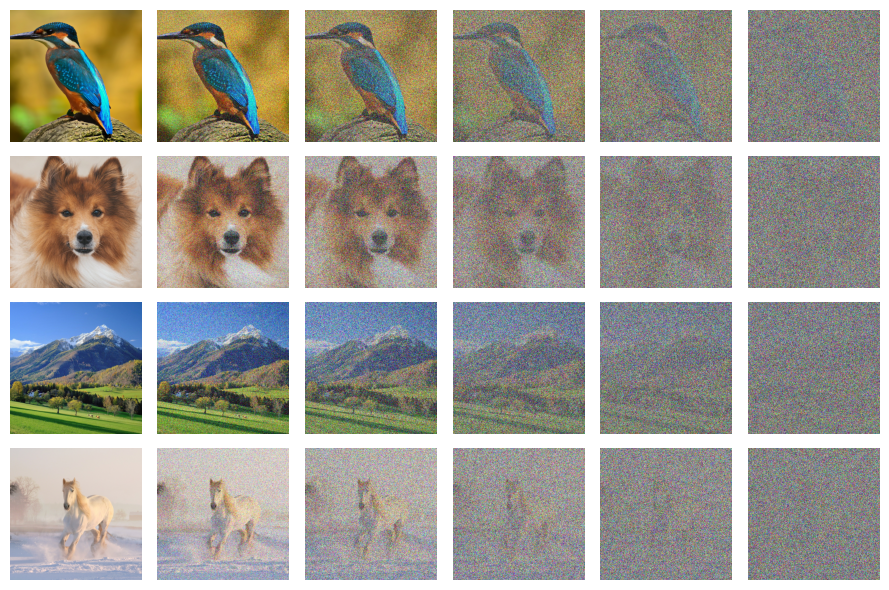

In [2]:
import matplotlib.pyplot as plt
import PIL
import numpy as np

# define a function to add noise to images
def linear_noisy_image(image,timestep):
    alphabar_t=linear_scheduler()["sqrtab"][timestep]
    noisy=image*torch.sqrt(alphabar_t)+\
        torch.randn_like(image)*torch.sqrt(1 - alphabar_t)
    return torch.clip(noisy,min=-1,max=1)
    
imgs=[]
# iterate through the four images
for name in ["bird","dog","mountains","horse"]:
    img=np.array(PIL.Image.open(f"files/{name}.png"))
    img=torch.tensor(2*(img/255)-1)
    # obtain the noisy images at time steps 0, 200, ..., 1000
    for timestep in [0,200,400,600,800,1000]:
        imgs.append(linear_noisy_image(img,timestep)/2+0.5)

# plot the images
plt.figure(figsize=(9,6),dpi=100)
for i in range(24):
    plt.subplot(4,6,i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

We first define a function linear_noisy_image() to add noise to an image. The function takes two arguments: image, which is a clean image that you want to add noise to; and timestep, which is an integer that can take a value between 0 and 1000. The result is a noisy image based on the formula  $$x_{t} = \sqrt{\bar{α}_t} x_0 + \sqrt{1-\bar{α}_t}\  \epsilon $$
where $x_0$ is the clean image you feed to the function, and t is the timestep argument in the function. 

We then iterate through the four images and the time steps 0, 200, 400, ..., 1000 and use the function linear_noisy_image() to generate 24 images. The 24 images are plotted in four rows and six columns, as shown above. The four images in the first column are clean images downloaded from the book's GitHub repository. We then gradually add noise to these images. As the timestep increases, more and more noise is injected into the images. The four images in the second column are images after 200 timesteps. The third column contains images after 400 time steps and they have more noise than those in the second column. The last column contains images after 1000 time steps and they are just random noise, indistinguishable from TV screen static. 

## 1.3 Different Diffusion Schedules
In 2021, Alex Nichol and Prafulla Dhariwal proposed a new noise schedule in their paper Improved Denoising Diffusion Probabilistic Models. They use a cosine diffusion schedule and find it outperforms the linear diffusion schedule proposed in the paper by Ho, Jain, and Abbeel in 2020. Specifically, they propose that:
$\bar{α}_t=cos^2(\frac{\pi t}{2T})$ and $1-\bar{α}_t=sin^2(\frac{\pi t}{2T})$. That is, we can sample $x_t$ as follows:

$$x_{t} = cos(\frac{\pi t}{2T}) x_0 + sin(\frac{\pi t}{2T})\  \epsilon $$

Compared to the linear diffusion schedule, the cosine diffusion schedule adds noise to the image more uniformly from time step 1 to time step T. To see this, run the following code block:

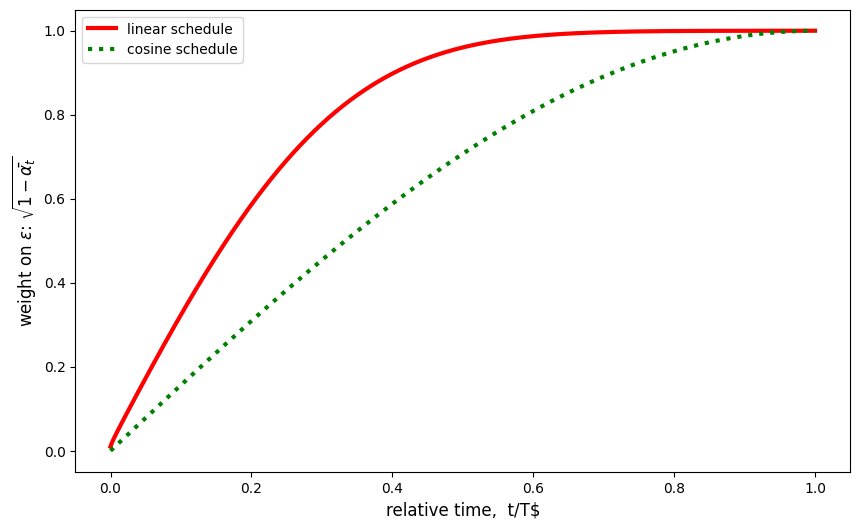

In [3]:
# define the cosine diffusion scheduler
import math
def cosine_scheduler():
    sqrtab = torch.cos(0.5*math.pi*t)
    sqrtmab = torch.sin(0.5*math.pi*t)
    return {"sqrtab": sqrtab,"sqrtmab": sqrtmab}

# plot the weight on the noise over time under the two schedules
plt.figure(figsize=(10,6),dpi=100)
plt.plot(t, linear_scheduler()["sqrtmab"], linewidth=3, 
         linestyle="solid",c="r", label="linear schedule")
plt.plot(t, cosine_scheduler()["sqrtmab"], linewidth=3, 
         linestyle="dotted",c="g", label="cosine schedule")
plt.xlabel(r"relative time,  t/T", fontsize=12)
plt.ylabel(r"weight on $\epsilon$: $\sqrt{1-\bar{\alpha_t}}$",
           fontsize=12)
plt.legend()
plt.show()

We first define a function cosine_scheduler() to define the weight placed on the clean image and that on the noise over time based on the cosine diffusion schedule. We then plot the weights on the noise under the two schedules in the same graphs. As you can see, the red solid line is the weight on the noise over time under the linear diffusion schedule. The weight is flat once the relative time step t/T exceeds 0.6. In contrast, if you look at the dotted green line, the weight on the noise under the cosine diffusion schedule increase over time gradually, leading to better learning in diffusion models. 

Run the following code block to visualize the weight placed on the clean image over time:

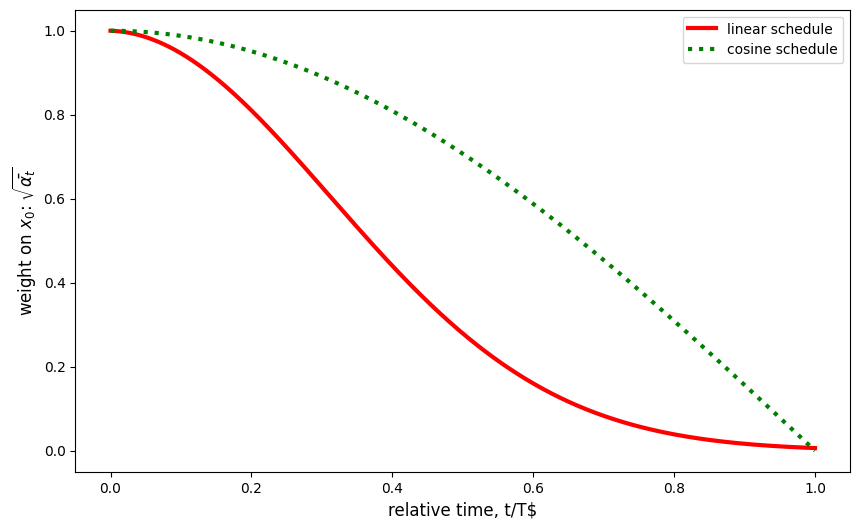

In [4]:
plt.figure(figsize=(10,6),dpi=100)
plt.plot(t, linear_scheduler()["sqrtab"], linewidth=3, 
         linestyle="solid",c="r", label="linear schedule")
plt.plot(t, cosine_scheduler()["sqrtab"], linewidth=3, 
         linestyle="dotted",c="g", label="cosine schedule")
plt.xlabel(r"relative time, t/T", fontsize=12)
plt.ylabel(r"weight on $x_0$: $\sqrt{\bar{\alpha_t}}$",
           fontsize=12)
plt.legend()
plt.show()

The red solid line shows the weight on the clean image over time under the linear diffusion schedule. The weight is flat once the relative time step t/T exceeds 0.8. In contrast, the dotted green line shows that the weight on the noise under the cosine diffusion schedule decrease over time gradually.

To see how this affects the actual diffusion process, download the image bunny.png from the book's GitHub repository and place it under the /files/ folder on your computer. Then run the following code block: 

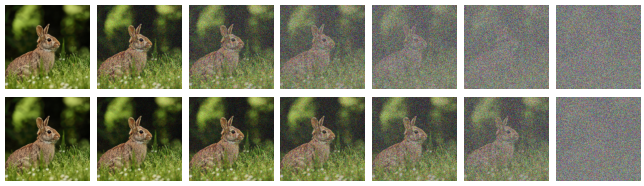

In [5]:
def cosine_noisy_image(image,timestep):
    alphabar_t=cosine_scheduler()["sqrtab"][timestep]
    noisy=image*torch.sqrt(alphabar_t)+\
        torch.randn_like(image)*torch.sqrt(1 - alphabar_t)
    return torch.clip(noisy,min=-1,max=1)

img=np.array(PIL.Image.open("files/bunny.png"))
img=torch.tensor(2*(img/255)-1)
imgs=[]

for timestep in [0,166,332,498,664,830,996]:
    imgs.append(linear_noisy_image(img,timestep)/2+0.5)
for timestep in [0,166,332,498,664,830,996]:
    imgs.append(cosine_noisy_image(img,timestep)/2+0.5)

plt.figure(figsize=(13,4),dpi=50)
for i in range(14):
    plt.subplot(2,7,i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

The top row of images shows how noise is added to the bunny image under the linear diffusion schedule. The bottom row shows how noise is added to the same bunny image under the cosine diffusion schedule As you can see, noise is added to the image more gradually and more evenly over time under the cosine diffusion schedule. This is the reason why the cosine diffusion schedule leads to better performance. 

# 2 The Reverse Diffusion Process 
Now that you understand the forward diffusion process, let’s discuss the reverse diffusion process (i.e., the denoising process). If we can train a model to reverse the forward diffusion process, we can feed the model with random noise and ask it to produce a noisy image. We can iteratively repeat the process for many time steps until we obtain a clean image. 

We usually use a U-Net as the denoising model. In the next chapter, you'll learn from scratch how to create a U-Net. In this chapter, we'll use the U-Net from the diffusers library. 

## 2.1 What is the reverse diffusion process
In the forward diffusion process, we add noise to sample $x_t$ to obtain $x_{t+1}$, based on a function $q(x_{t+1}|x_t)$. However, upon observing $x_{t+1}$, we cannot obtain $x_t$ because the function $q(x_t)|x_{t+1})$ is unknown. 

Therefore, we need to use training data to learn a model to approximate the conditional probability $p_{\theta}(x_t)|x_{t+1})$, where $\theta$ are model parameters. The idea is shown in the following diagram: 

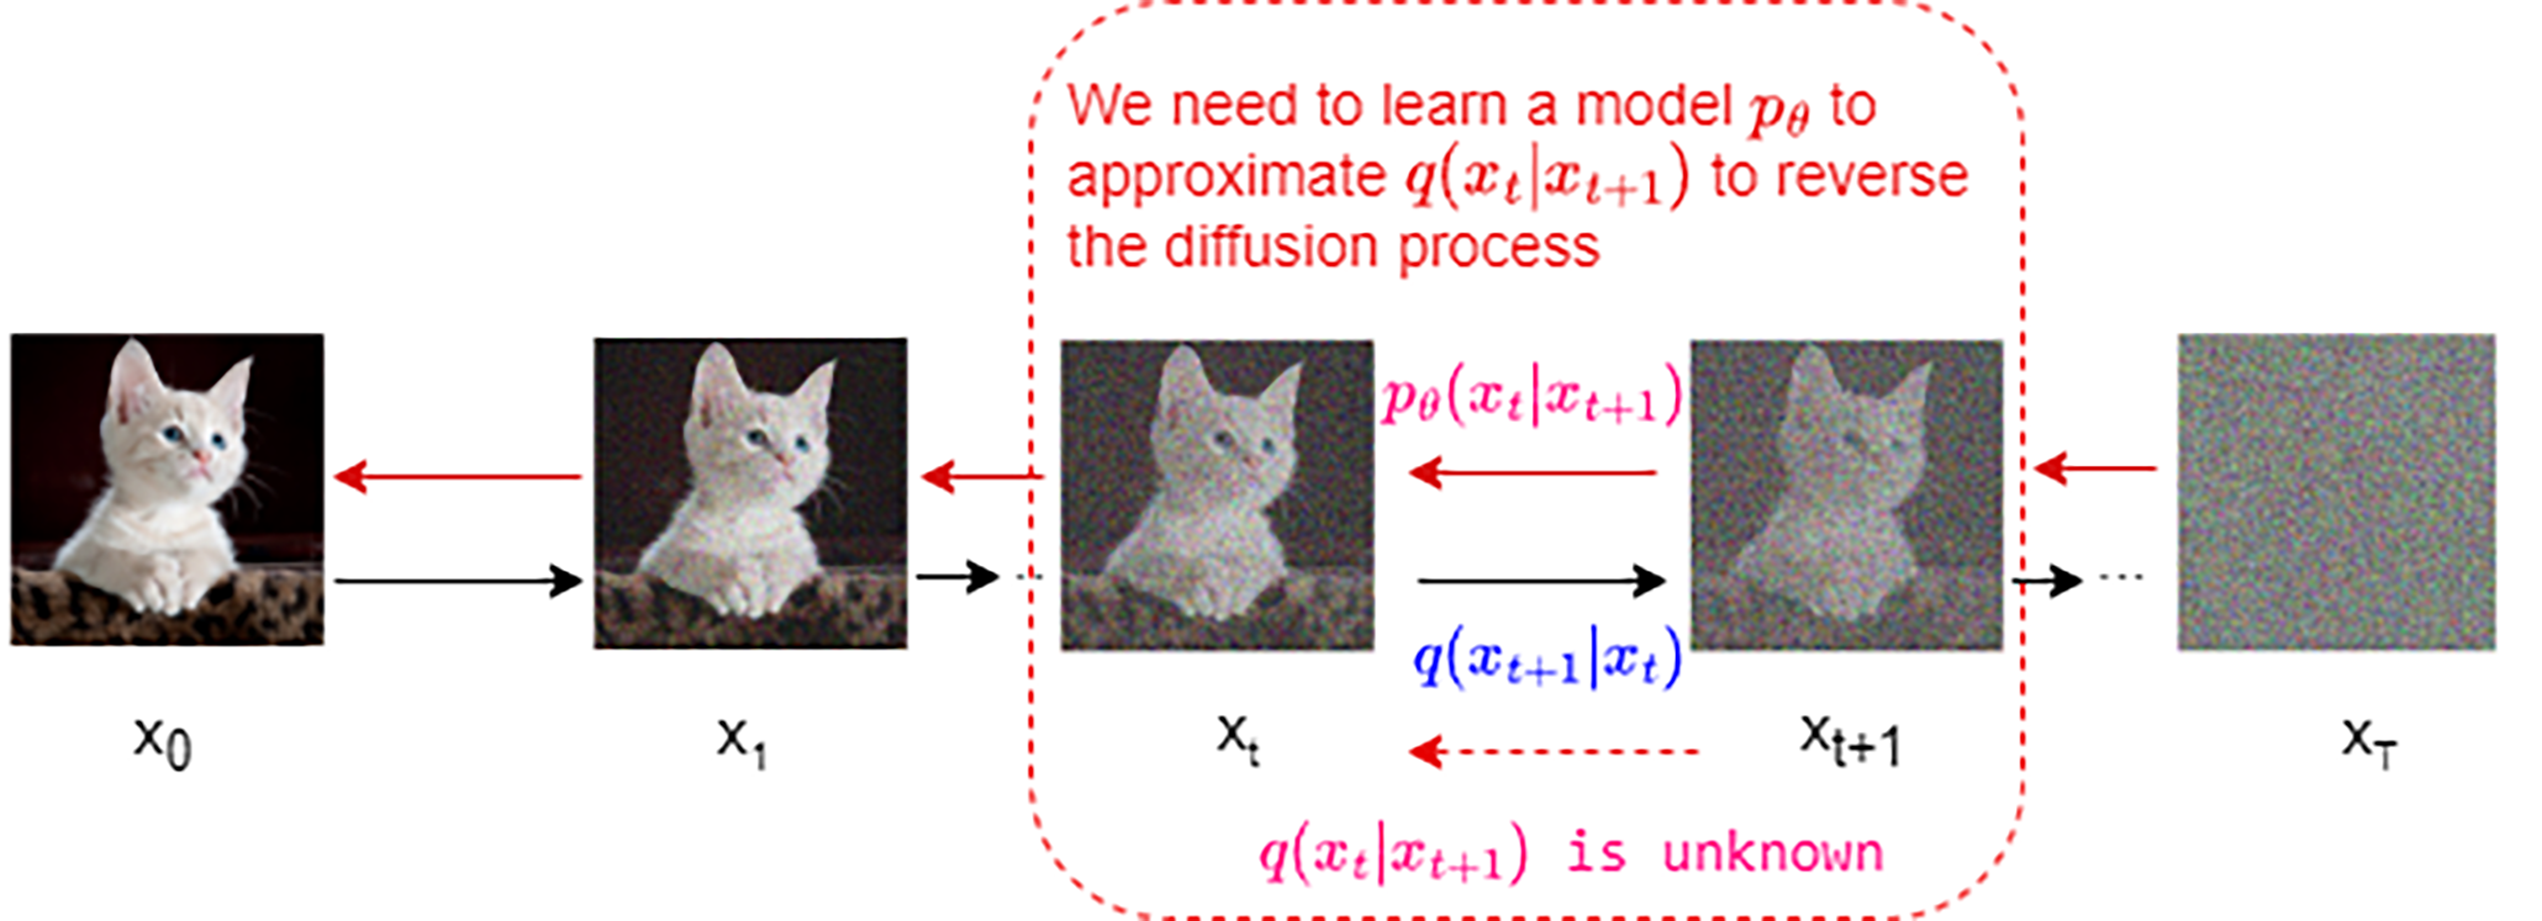

## 2.2 A Denoising U-Net Model
The U-Net architecture is originally designed for biomedical image segmentation. It has a symmetric shape, with a contracting path (encoder) and an expansive path (decoder), connected by a bottleneck layer. In the context of denoising, U-Net models are adapted to remove noise from images while preserving important details. U-Nets outperform simple convolutional networks in denoising tasks due to their efficient capturing of local and global features in images. 

In the next chapter, you'll learn to create a U-Net from scratch for denoising purposes. In this chapter, we'll build the following denoising U-Net model by using the diffusers library.

In [6]:
import diffusers
import torch

device="cuda" if torch.cuda.is_available() else "cpu"
model=diffusers.UNet2DModel(sample_size=32,in_channels=1,
                    out_channels=1,layers_per_block=2,
    block_out_channels=(128,128,256,512),
    down_block_types=("DownBlock2D","DownBlock2D",
                      "AttnDownBlock2D","DownBlock2D",),
    up_block_types=("UpBlock2D","AttnUpBlock2D",
                "UpBlock2D","UpBlock2D",),).to("cuda")

The input to the model is a noisy image, $x_{t}$, along with which the time step t. The model will predict the noise in the image. Once we know the noise in the image, we can back out the original clean image $x_{0}$. 

# 3. Prepare for training
In this section, we'll discuss the steps in training a denoising U-Net model. We'll then preprocess the training data to get it ready for the next section.

# 3.1 Steps in training a denoising U-Net model
The denoising U-Net takes a noisy image and the time step it's in as inputs. The output is the noise injected into the noisy image. The model is trained to minimize the difference between the output (predicted noise) and the ground truth (actual noise). 

The denoising U-Net model leverages the U-Net architecture's ability to capture both local and global context, making it effective for removing noise while preserving important details such as edges and textures. These models are widely used in various applications, including medical image denoising and  photographic image restoration. 
The diagrm below shows the steps in training a denoising U-Net model.

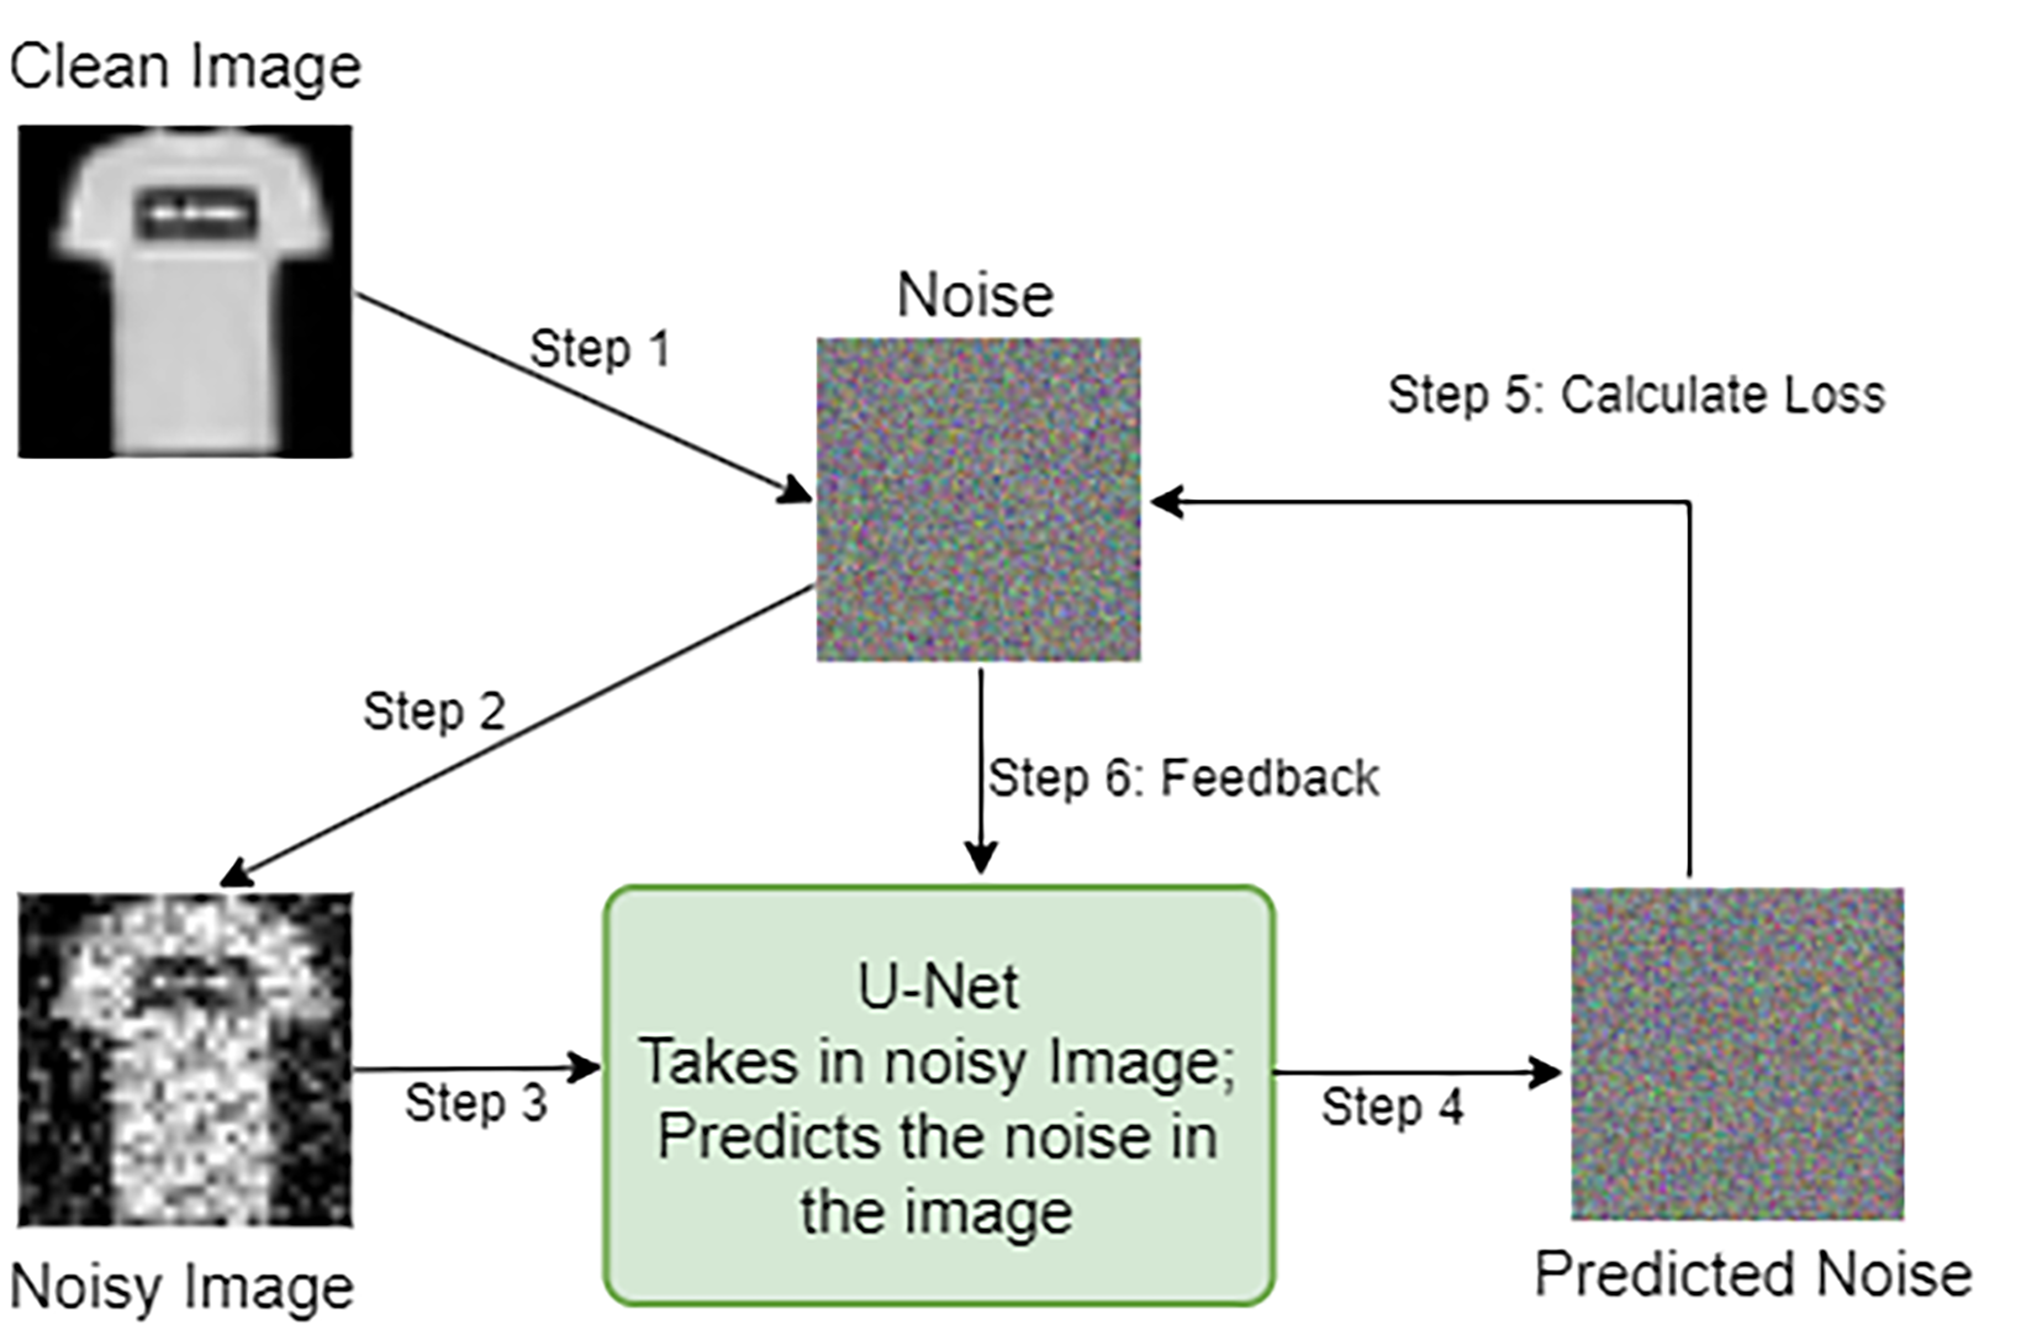 

We first obtain clean clothing item images as our training set. We add noise to clean images and present them to the U-Net model. The model predicts the noise in the noisy images. We compare the predicted noise with the ground truth (the actual noise injected into the images) and tweak the model weights to minimize the losses. Eiher the L1 loss (mean absolute error) or the L2 loss (mean squared error) can be used as the loss in this situation. There is a trade-off. L1 loss is less sensitive to outliers compared to the L2 loss. It's a matter of how much you want to punish the outliers. In our setting, we find that L1 loss performs slightly better than L2 loss.

# 3.2 Prepare for the training data
We’ll be using the Fashion Modified National Institute of Standards and Technology (MNIST) dataset
in this project. Along the way, you'll learn how to use the datasets and transforms packages in the
Torchvision library, as well as the Dataloader packages in PyTorch that will help you for the rest of
the book. You'll use these tools to preprocess data throughout the book.
We first import needed libraries and instantiate a Compose() class in the transforms packages to
transform raw images to PyTorch tensors:

In [7]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

torch.manual_seed(42)

tf = transforms.Compose(
    [transforms.Resize((32,32)),transforms.ToTensor(),
     transforms.Lambda(lambda x: 2*(x-0.5)),]
)

The manual_seed() method in PyTorch is used to fix the random state so that results are
reproducible. The transforms package in Torchvision can help create a series of transformations to
preprocess images. We resize the images from (1, 28, 28) to (1, 32, 32) so that the images fit the input dimensions of the 
U-Net model we created in the last section. The ToTensor() class converts image data (in either PIL image formats or NumPy
arrays) into PyTorch tensors. In particular, the image data are integers ranging from 0 to 255 and
the ToTensor() class converts them to float tensors with values in the range of 0.0 and 1.0.
We then normalize the input
data to the range [-1, 1] for faster convergence during training and you’ll do this often in this
book.

Next, we use the datasets package in Torchvision to download the dataset to a folder on your
computer and perform the transformation, like so:

In [8]:
dataset = torchvision.datasets.FashionMNIST(
    r"D:\temp",
    train=True,
    download=True,
    transform=tf,
)

There are ten different types of
clothing items. The labels in the dataset are numbered from 0 to 9. The list text_labels below contains the ten text labels
corresponding to the numerical labels 0 to 9. For example, if an item has a numerical label of 0 in
the dataset, the corresponding text label is "t-shirt". The list text_labels is defined as follows:

In [9]:
text_labels=['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

We can plot the data to visualize the clothes items in the dataset:

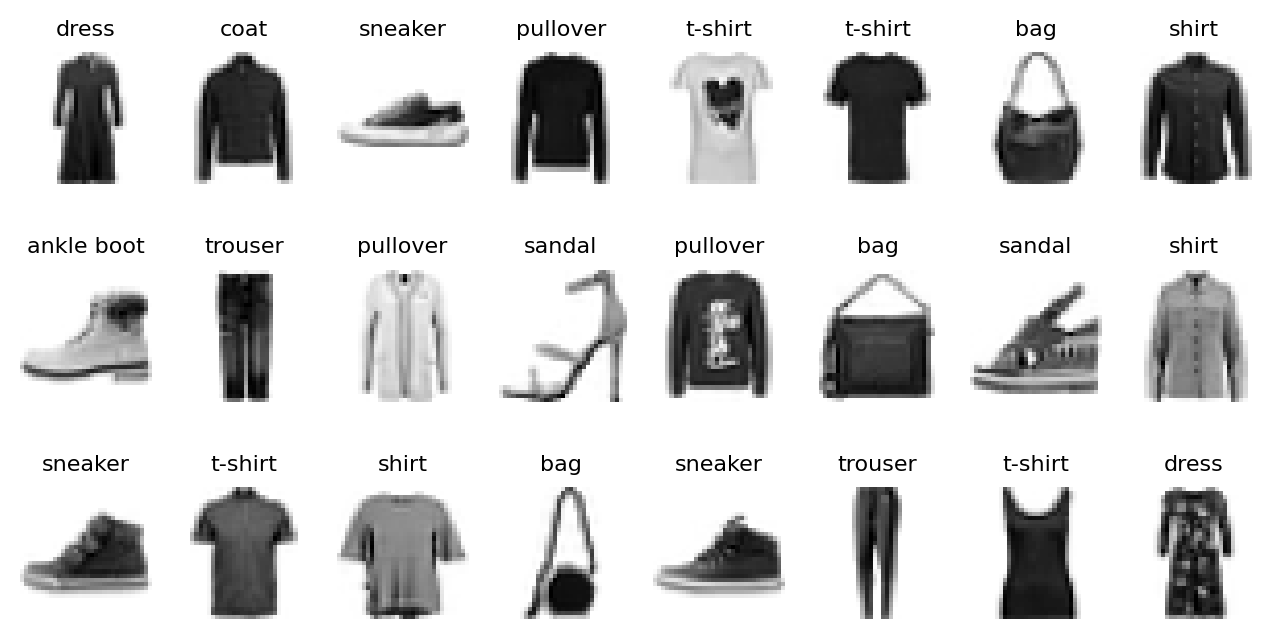

In [10]:
import matplotlib.pyplot as plt
plt.figure(dpi=200,figsize=(8,4))
for i in range(24):
    ax=plt.subplot(3, 8, i + 1) 
    img=dataset[i+888][0] 
    img=img/2+0.5 
    img=img.reshape(32,32) 
    plt.imshow(img,
    cmap="binary")
    plt.axis('off')
    plt.title(text_labels[dataset[i+888][1]],fontsize=8)
plt.show()

Finally, we put the training data in batches, as follows:

In [11]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# 4. Train and Use the Diffusion Model
Now that we have the denoising U-Net model and the training data, we'll train the model and use it to generate clothing item images. 

## 4.1 The DDPM Noise Scheduler
Earlier in the chapter, we discussed the idea behind noise schedulers. In the next chapter, we'll code from scratch a fully fledged noise that can handle both the forward and the reverse diffusion process. In this chapter, we'll rely on the noise scheduler in the diffusers library. 

Specifically, we define the noise schedule in our model as follows:

In [12]:
noise_scheduler = diffusers.DDPMScheduler(
    num_train_timesteps=1000,
  beta_schedule="squaredcos_cap_v2")

The DDPMScheduler() class from the diffusers library is used here. The argument num_train_timesteps=1000 specifies the number of time steps used in the diffusion process. We use a modified version of cosine diffusion scheduler here. The squaredcos_cap_v2 diffusion scheduler is a component of the diffusers library, specifically used in the Denoising Diffusion Probabilistic Models (DDPM) framework. This scheduler is responsible for managing the diffusion process, which involves gradually adding noise to an image and then learning to denoise it to generate new samples. It uses a cosine-based schedule with specific adjustments to improve the training stability and sample quality. It modifies the noise schedule to better match the denoising process, potentially leading to better sample quality. The cap in the name indicates that there is a capping mechanism to ensure the noise levels do not exceed certain limits, preventing excessive noise addition and helping maintain stability. That is, the noise level $β_t$ at timestep t is typically computed using a cosine function, modified with a squared term and capped to a maximum value.

## 4.2 Inference using the U-Net denoising model
During training, we'll periodically ask the model to generate images so that we can monitor the training process. For that purpose, we define the following sample() function.

In [13]:
# sampling
@torch.no_grad()
def sample(n_sample, model, noise_scheduler,seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    noise_scheduler.set_timesteps(1000)
    image=torch.randn((n_sample,1,32,32)).to(device)
    for t in noise_scheduler.timesteps:
        model_output=model(image,t)['sample']
        image=noise_scheduler.step(model_output,int(t),
                       image,generator=None)['prev_sample']        
    return image

The function takes several arguments. The first argument n_sample specifies how many images you want to generate. The argument model is the denoising U-Net model you want to use to generate images and the noise_scheduler argument specifies the noise scheduler to use. Finally, you can choose a random seed if you want to reproduce the results. 

## 4.3 Train and use the denoising U-Net model
We'll use the AdamW optimizer with a learning rate of 0.0002:

In [14]:
optim = torch.optim.AdamW(model.parameters(), lr=2e-4)

We'll use PyTorch’s automatic mixed precision package torch.cuda.amp to speed up training. The
default data type in PyTorch tensors is float32, a 32-bit floating-point number, which takes up twice
as much memory as a 16-bit floating number, float16. Operations on the former are slower than
those on the latter. There is a trade-off between precision and computational costs. Which data
type to use depends on the task at hand. torch.cuda.amp provides an automatic mixed precision,
where some operations use float32 and others float16. Mixed precision tries to match each
operation to its appropriate data type to speed up training.

We train the model for ten epochs:

In [15]:
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

scaler = torch.cuda.amp.GradScaler()
for i in range(10):
    pbar = tqdm(dataloader)
    loss_ema = None
    for x, _ in pbar:
        x = x.to(device)
        with torch.cuda.amp.autocast():
            noise=torch.randn_like(x).to(device)
            timesteps=torch.randint(0,
                    noise_scheduler.config.num_train_timesteps,
                                    (x.shape[0],),device=device)
            noisy=noise_scheduler.add_noise(x, noise, timesteps)
            noise_pred=model(noisy,timesteps)["sample"]
            loss = torch.nn.functional.l1_loss(noise_pred,noise)
        optim.zero_grad() 
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}")
    xh = sample(32, model, noise_scheduler)
    grid = make_grid(0.5-xh/2, nrow=8)
    save_image(grid, f"files/diffusion_fashion{i}.png")
# save model
torch.save(model.state_dict(), "files/diffusion_fashion.pth")

The training takes about 30 minutes if you use GPU training. Otherwise it takes a few hours. The trained model is saved on your computer. Alternatively, you can download the trained model form my website here 
https://gattonweb.uky.edu/faculty/lium/gai/diffusion_fashion.ph
. Unzip the file after downloading. 

Let's load up the trained model and generate some images: 

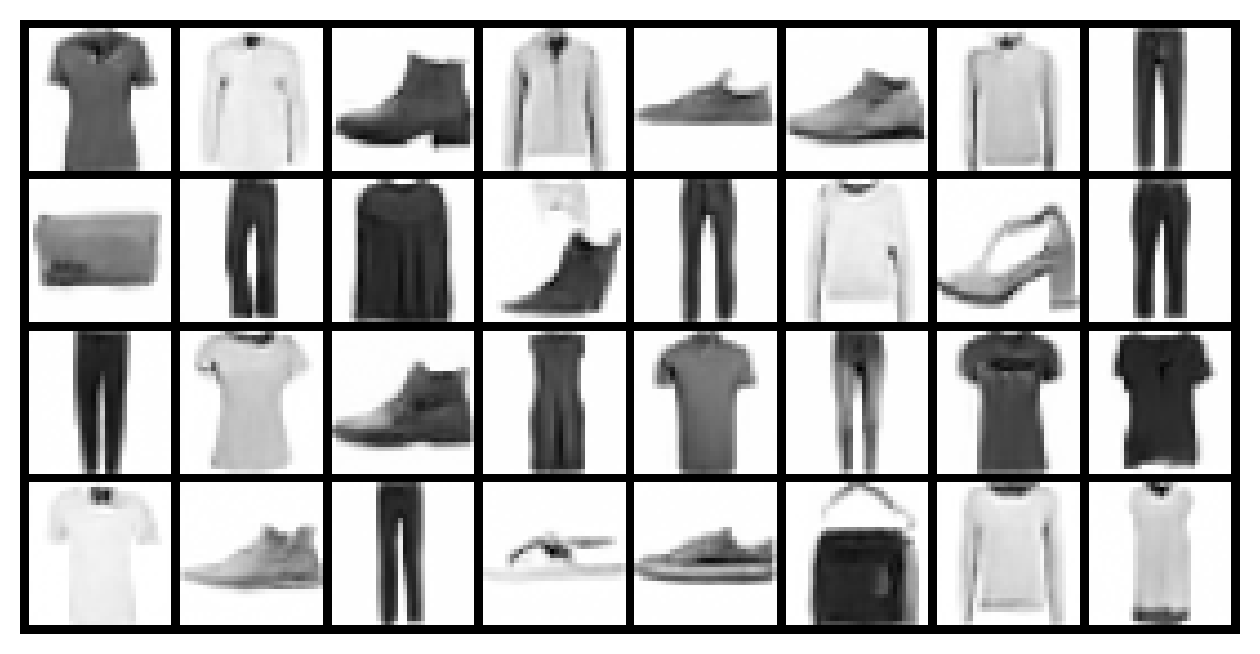

In [16]:
model.load_state_dict(torch.load(
    "files/diffusion_fashion.pth",
         map_location=device))
generated_images = sample(32, model, noise_scheduler)
grid = make_grid(0.5-generated_images/2, nrow=8)
save_image(grid, f"files/diffusion_fashion.png")

plt.figure(dpi=200)
plt.imshow(grid.cpu().permute(1,2,0))
plt.axis('off')
plt.tight_layout()
plt.show()

As you can see, the trained denoising U-Net model generates clothing item images resembling those in the training dataset. 

You may be wondering, can I control the model to generate the items I want, such as a sandal, a t-shirt, or a coat? It turns out you can. In the next chapter, you'll learn to create and train a diffusion model to take in conditioning information (such as the label of a clothing item) so that the model creates an image that you want. 